<a href="https://colab.research.google.com/github/junho328/Dacon/blob/main/KBO_Batter_OPS_Prediction_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,135 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# 3.1 결측치 처리 및 데이터 오류 처리

In [ ]:
 regular_season_df = pd.read_csv('/content/drive/MyDrive/DayCon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/Regular_Season_Batter.csv')

In [ ]:
pd.DataFrame(regular_season_df.isna().sum()).transpose()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,0,0,0,26,0,0,0,0,0,...,0,26,24,0,802,0,802,0,1067,26


- 타율(AVG), 장타율(SLG), 출루율(OPS) 등의 변수에 결측치 존재

In [ ]:
# 수치형 타입의 변수 저장
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = regular_season_df.select_dtypes(include=numerics).columns

# 수치형 타입 변수 중 결측치가 하나라도 존재하는 행 출력

# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[num_cols].isna().sum(axis=1) > 0, num_cols].head()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,...,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
18,138,2013,NaN,2,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,0,NaN
175,21,2000,NaN,3,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,0,NaN
200,24,2002,NaN,1,0,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,0,NaN
265,31,2007,NaN,1,0,1,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,0,NaN
385,45,2007,NaN,3,0,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,0,NaN


- G는 선수가 뛴 경기 수를 의미한다
  - 뛴 경기가 적어 성적을 산출하지 못하는 경우에 결측치가 발생하는 것으로 확인된다

=> 정규시즌과 일별 데이터, 프리시즌 데이터 모두 결측치를 0으로 대체하겠다

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# 정규 시즌 데이터에서 결측치를 0으로 채우기
regular_season_df[regular_season_df.select_dtypes(include=numerics).columns] = regular_season_df[regular_season_df.select_dtypes(include=numerics).columns].fillna(0)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,...,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.761


In [ ]:
# 일별 데이터에서 결측치를 0으로 채우기
day_by_day_df = pd.read_csv('/content/drive/MyDrive/DayCon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/Regular_Season_Batter_Day_by_Day_b4.csv')
day_by_day_df[day_by_day_df.select_dtypes(include=numerics).columns] = day_by_day_df[day_by_day_df.select_dtypes(include=numerics).columns].fillna(0)
day_by_day_df

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112268,344,황진수,6.23,LG,-,0,0,0,0,0,0,0,0,0,1,0,0,0,0.158,2018
112269,344,황진수,6.26,넥센,0.000,1,0,0,0,0,0,0,0,0,0,0,1,0,0.150,2018
112270,344,황진수,6.27,넥센,0.500,2,1,1,1,0,0,0,0,0,0,0,1,0,0.182,2018
112271,344,황진수,6.28,넥센,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0.182,2018


In [ ]:
# 프리 시즌 데이터에서 결측치를 0으로 채우기
preseason_df = pd.read_csv('/content/drive/MyDrive/DayCon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/Pre_Season_Batter.csv')
preseason_df[preseason_df.select_dtypes(include=numerics).columns] = preseason_df[preseason_df.select_dtypes(include=numerics).columns].fillna(0)
preseason_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,...,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,...,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,...,0,0.000,0.000,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
3,1,강경학,2015,한화,0.130,10,23,3,3,0,...,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,...,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,...,0,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,...,0,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,...,0,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,...,0,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833


In [ ]:
# 수치형이 아닌 변수 추출
not_num_cols = [x for x in regular_season_df.columns if x not in num_cols]

# 수치형이 아닌 변수 중 결측치가 하나라도 존재하는 행 출력

# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[not_num_cols].isna().sum(axis=1)>0, not_num_cols].head() 

,batter_name,team,height/weight,year_born,position,career,starting_salary
0,가르시아,LG,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN
12,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN
13,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN
14,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN
15,백승룡,한화,NaN,1982년 08월 16일,NaN,사직초(부산극동리틀)-사직중-경남상고-경성대-한화-넥센,NaN


- 키,몸무게,포지션,초봉 등의 결측치가 존재
  - 추가로 KBO 사이트를 통해 크롤링으로 보완할 수 있지만, 추후 분석 과정에 이용하지 않은 예정이므로 따로 결측치 처리를 하지 않는다

In [ ]:
# 잘못된 결측 데이터 삭제

drop_idx = regular_season_df.loc[
    # 안타가 0개 이상이면서 장타율이 0인 경우
    ((regular_season_df['H']>0) & (regular_season_df['SLG']==0))|
    
    # 안타가 0개 이상 혹은 볼넷이 0개 이상 혹은 몸에 맞은 볼이 0개 이상이면서 출루율이 0인 경우
    (((regular_season_df['H']>0)|
      (regular_season_df['BB']>0)|
      (regular_season_df['HBP']>0))&
      (regular_season_df['OBP']==0))
].index

# 데이터 삭제
regular_season_df = regular_season_df.drop(drop_idx).reset_index(drop=True)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,...,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,...,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,...,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,...,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,344,황진수,2014,롯데,0.000,5,5,0,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2443,344,황진수,2015,롯데,0.000,2,2,0,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2444,344,황진수,2016,롯데,0.000,11,10,2,0,0,...,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.000
2445,344,황진수,2017,롯데,0.291,60,117,18,34,6,...,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000만원,0.761


#3.2 규정 타수 정의
- 선수들의 성적을 분석하는 데 있어 규정 타수를 정의하는 것은 매우 중요하다
  - 타수가 작은 선수는 출루율이나 장타율이 매우 높거나 낮게 형성될 확률이 크기 때문이다

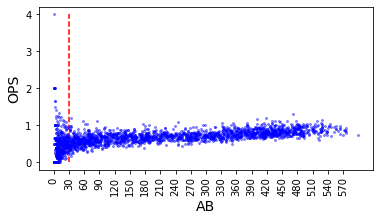

In [ ]:
# 타수에 따른 OPS 수치를 시각화
plt.figure(figsize=(6,3))
plt.plot('AB','OPS', data=regular_season_df, linestyle='none',marker='o',markersize=2,color='blue',alpha=0.4)
plt.xlabel('AB',fontsize=14)
plt.ylabel('OPS',fontsize=14)
plt.xticks(list(range(min(regular_season_df['AB']), max(regular_season_df['AB']),30)), rotation= 90)
plt.vlines(30,ymin = min(regular_season_df['OPS']), ymax=max(regular_season_df['OPS']),linestyles='dashed', colors='r')

- 규정 타수가 적은 특정한 구간에서 OPS가 매우 넓게 분포하고 있다
  - 특히 타수가 30 미만인 경우에 대해서는 OPS 분포가 매우 넓다

- 따라서 30을 규정 타수로 정의하고 분석을 진행한다

In [ ]:
# OPS 이상치 탐색을 위한 수치 정의
Q1 = regular_season_df['OPS'].quantile(0.25)
Q3 = regular_season_df['OPS'].quantile(0.75)
IQR = Q3-Q1

# 실제 OPS 이상치 탐색
regular_season_df.loc[(regular_season_df['OPS'] < (Q1-1.5*IQR))|
                      (regular_season_df['OPS'] > (Q3+1.5*IQR))].sort_values(
                          by = ['AB'], axis = 0, ascending=False)[['batter_name','AB','year','OPS']].head(10)

,batter_name,AB,year,OPS
2329,테임즈,472,2015,1.293656
97,강정호,418,2014,1.200156
1318,유재신,33,2018,1.192000
416,김원섭,25,2005,0.116923
1543,이여상,22,2013,0.090909
681,문규현,18,2007,0.109000
578,김회성,17,2010,0.105000
1902,정병곤,15,2018,0.130000
1874,정경운,15,2018,0.130000
2384,현재윤,15,2014,1.229167


- 상반기 성적을 정의하기 위해 며칠까지의 기록을 상반기로 정의할 것인지 결정한다
  - 야구는 7월 중순쯤에 일주일 정도 휴식기를 갖는다. 보통 이 휴식 전을 상반기로 본다.
  - 따라서 이 휴식 기간에는 야구 경기 수가 다른 날짜에 비해 적을 것이다

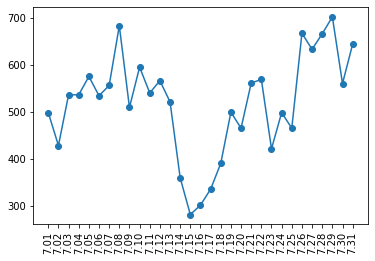

In [ ]:
# 7월 한 달 동안 경기를 뛴 선수들의 수의 합

major_ticks = list(np.round(np.linspace(7.01,7.31,31),2))

july = (day_by_day_df['date'] >= 7) & (day_by_day_df['date']<8) # 7월만 불러오는 index

plt.plot(major_ticks, day_by_day_df['date'].loc[july].value_counts().sort_index(), marker='o')
plt.xticks(major_ticks, rotation=90)
plt.show()

- 다른 날짜들과 달리 7.14 ~ 7.18ㅇ은 확연하게 경기 수가 적다
  - 따라서 7월 18일을 전체 시즌의 휴식 기간이라고 볼 수 있다

# 3.2 시간변수
- 시기에 따른 선수들의 성적 데이터를 제공하고 있으므로 시계열 특성을 정확하게 파악하는 것이 중요하다
- 즉, 시계열 정보를 반영하기 위한 방법은 많지만 이번에는 시간 변수 생성에 초점을 맞춰 문제를 해결해본다.

In [ ]:
# 시간 특성을 좀 더 정확히 반영하기 위해 선수별로 과거 성적을 만들어주는 함수를 정의

In [ ]:
# 시간변수를 생성하는 함수 정의
def lag_function(df, var_name, past):
  # df = 시간변수를 생성할 데이터 프레임
  # var_name = 시간변수 생성의 대상이 되는 변수 이름
  # past = 몇 년 전의 성적을 생성할지 결정

  df.reset_index(drop=True, inplace=True)
  
  # 시간변수 생성
  df['lag'+str(past)+'_'+var_name] = np.nan
  df['lag'+str(past)+'_'+'AB'] = np.nan

  for col in ['AB', var_name]:
    for i in range(0, (max(df.index)+1)):
      val = df.loc[(df['batter_name']==df['batter_name'][i])&
                   (df['year'] == df['year'][i] - past), col]
      # 과거 기록이 결측치가 아니라면 값을 넣기
      if len(val) != 0:
        df.loc[i, 'lag'+str(past)+'_'+col] = val.iloc[0]
  
  # 30타수 미만 결측치 처리
  df.loc[df['lag'+str(past)+'_'+'AB']<30,
         'lag'+str(past)+'_'+var_name] = np.nan
  df.drop('lag'+str(past)+'_'+'AB',axis=1,inplace=True)

  return df

- 변수 선택 & 시간 범위
  - 과거의 어떤 성적을 이용해야 할지, 과거의 성적을 얼마나 이용해야 하는지에 대한 결정이 필요하다
  - 이를 확인하기 위해 상관관계를 기반으로 필요한 변수를 선택하고 기간을 설정한다

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

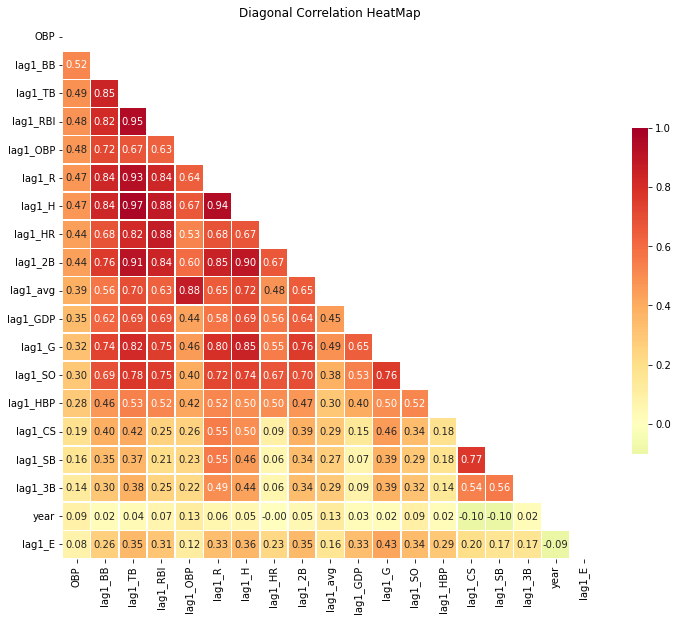

In [ ]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(['batter_id','year','OPS','SLG'],axis=1).columns)
regular_season_temp = regular_season_df[numeric_cols+['year','batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB']>=30]

# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
  regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('OBP')
regular_season_temp.drop(numeric_cols,axis=1,inplace=True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by='OBP', axis=0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12,12))
corr = regular_season_temp.select_dtypes(exclude=['object','bool']).corr()

# 대각 행렬을 기준으로 한쪽만 나타나게 설정
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax=1, mask=mask, center=0, annot=True, fmt='.2f',square=True, linewidth=.5,cbar_kws={'shrink':.5})
plt.title('Diagonal Correlation HeatMap')

- OBP를 기준으로 확인한 결과, 특정 연도의 OBP와 과거의 OBP가 높은 상관성을 띠고 있다
- BB(볼넷)와 같이 OBP와 높은 상관관계를 보여주는 지표가 더 존재하지만, 이들은 모두 1년 전의 OBP와도 높은 상관관계를 보여준다
  - 독립변수 간 상관관계가 높은 상태에서 분석을 진행할 경우, 다중공선성 등의 문제가 생길 수 있으므로 BB와 같은 변수는 삭제하는 것이 타당하다.

=> 즉, OBP를 예측할 때는 해당 선수의 과거 OBP만을 이용하겠다.

In [ ]:
# 희생 플라이 계산

# OBP(출루율) 계산 공식 이용하여 SF(희생 플라이) 계산 >> (H+BB+HBP)/OBP-(AB+BB+HBP)
regular_season_df['SF'] = regular_season_df[['H','BB','HBP']].sum(axis=1) / regular_season_df['OBP']-regular_season_df[['AB','BB','HBP']].sum(axis=1)
regular_season_df['SF'].fillna(0,inplace=True)
regular_season_df['SF'] = regular_season_df['SF'].apply(lambda x : round(x,0))

# 한 타수당 평균 희생 플라이 계산 후 필요한 것만 추출
regular_season_df['SF_1'] = regular_season_df['SF'] / regular_season_df['AB']
regular_season_df_SF = regular_season_df[['batter_name','year','SF_1']]
regular_season_df_SF

,batter_name,year,SF_1
0,가르시아,2018,0.032787
1,강경학,2011,0.000000
2,강경학,2014,-0.000000
3,강경학,2015,0.009646
4,강경학,2016,0.009901
...,...,...,...
2442,황진수,2014,0.000000
2443,황진수,2015,0.000000
2444,황진수,2016,0.000000
2445,황진수,2017,0.008547


In [ ]:
# day_by_day에서 연도별 선수의 시즌 상반기 출루율과 관련된 성적 합 구하기
sum_hf_yr_OBP = day_by_day_df.loc[day_by_day_df['date']<=7.18].groupby(['batter_name','year',])['AB','H','BB','HBP'].sum().reset_index()

# day_by_day와 regular_season에서 구한 희생 플라이 관련 데이 합치기
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df_SF, how='left',on=['batter_name','year'])

# 선수별 상반기 희생 플라이 수 계산
sum_hf_yr_OBP['SF'] = (sum_hf_yr_OBP['SF_1'] * sum_hf_yr_OBP['AB']).apply(lambda x: round(x,0))
sum_hf_yr_OBP.drop('SF_1', axis=1, inplace=True)

# 선수별 상반기 OBP(출루율) 계산
sum_hf_yr_OBP['OBP'] = sum_hf_yr_OBP[['H','BB','HBP']].sum(axis=1) / sum_hf_yr_OBP[['AB','BB','HBP','SF']].sum(axis=1)

# OBP 결측치를 0으로 처리
sum_hf_yr_OBP['OBP'].fillna(0,inplace=True)

# 분석에 필요치 않은 열 제거
sum_hf_yr_OBP = sum_hf_yr_OBP[['batter_name','year','AB','OBP']]
sum_hf_yr_OBP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,batter_name,year,AB,OBP
0,가르시아,2018,85,0.418367
1,강경학,2011,1,0.000000
2,강경학,2014,0,1.000000
3,강경학,2015,156,0.342541
4,강경학,2016,81,0.222222
...,...,...,...,...
1381,황진수,2012,4,0.400000
1382,황진수,2013,0,0.000000
1383,황진수,2016,9,0.000000
1384,황진수,2017,71,0.316456


#3.4 추가 변수 생성
  - 일반적으로 운동선수는 나이에 따라 잘하는 시기가 정해져 이쓴 경우가 많다
  - 따라서 나이를 고려할 필요성이 있다

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_te

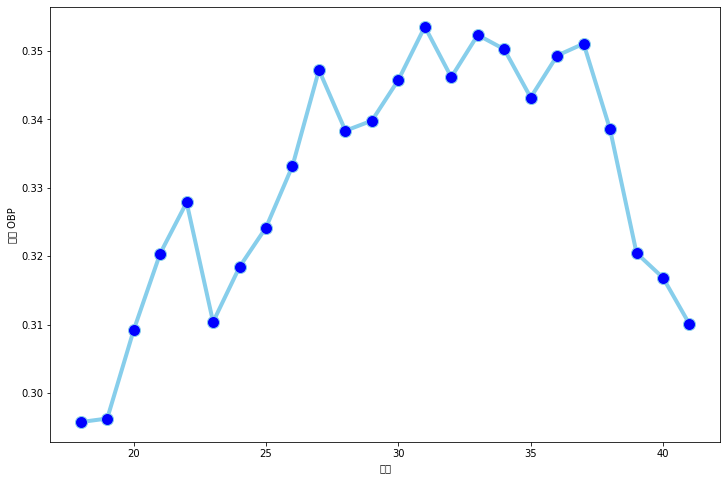

In [ ]:
# 나이에 따른 OBP 성적 변화 추이 시각화

# 나이 변수 생성
regular_season_df['age'] = regular_season_df['year'] - regular_season_df['year_born'].apply(lambda x: int(x[:4]))

# 나이, 평균 출루율, 출루율 중앙값으로 구성된 데이터프레임 구축
temp_df = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('age').agg(
    {'OBP':['mean','median']}).reset_index()
temp_df.columns = temp_df.columns.droplevel()
temp_df.columns = ['age','mean_OBP','median_OBP']

plt.figure(figsize=(12,8))
plt.plot('age','mean_OBP', data=temp_df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.ylabel('평균 OBP')
plt.xlabel('나이')
plt.show()

- 시각화 결과, 확실히 나이에 따라 출루율의 추이가 존재한다
- 20대 후반에서 30대 초중반 사이의 구간 이전에는 출루율이 상승하는 경향이 있고, 이후 구간에는 출루율이 하락하는 경향이 있다

In [ ]:
# 나이를 포함한 변수 선택
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df[['batter_name','year','age']],how='left',on=['batter_name','year'])

# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP,'OBP',1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP,'OBP',2)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP,'OBP',3)
sum_hf_yr_OBP 

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN
...,...,...,...,...,...,...,...,...
1381,황진수,2012,4,0.400000,23,NaN,NaN,NaN
1382,황진수,2013,0,0.000000,24,NaN,NaN,NaN
1383,황진수,2016,9,0.000000,27,NaN,NaN,NaN
1384,황진수,2017,71,0.316456,28,NaN,NaN,NaN


# 3.5 데이터 사후 처리
- 모델 생성에 들어갈 수 있는지 확인하기 위해 결측치를 다시 파악한다

In [ ]:
round(sum_hf_yr_OBP[['lag1_OBP','lag2_OBP','lag3_OBP']].isna().sum()/ sum_hf_yr_OBP.shape[0],2)

lag1_OBP    0.41
lag2_OBP    0.54
lag3_OBP    0.61
dtype: float64

- 결측치 처리 방법
1. 선수별 출루율의 평균치를 구한다
2. 시즌별 출루율의 평균치를 구한다

In [ ]:
# 1.선수별 OBP 평균
# SF = (H+BB+HBP)/OPB-(AB+BB+HBP)
# OBP = (H+BB+HBP)/(AB+BB+HBP+SF)
player_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','BB','HBP','SF'].sum().reset_index()

player_OBP_mean['mean_OBP'] = player_OBP_mean[['H','BB','HBP']].sum(axis=1) / player_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)

# 2.시즌별 OBP 평균
season_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','BB','HBP','SF'].sum().reset_index()

season_OBP_mean['mean_OBP'] = season_OBP_mean[['H','BB','HBP']].sum(axis=1) / season_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)
season_OBP_mean = season_OBP_mean[['year','mean_OBP']]

### player_OBP_mean 열 추가
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(player_OBP_mean[['batter_name','mean_OBP']],how='left',on='batter_name')
sum_hf_yr_OBP = sum_hf_yr_OBP.loc[~sum_hf_yr_OBP['mean_OBP'].isna()].reset_index(drop=True)

sum_hf_yr_OBP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN,0.383495
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN,0.337880
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN,0.337880
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN,0.337880
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,NaN,NaN,NaN,0.358779
1348,황진수,2013,0,0.000000,24,NaN,NaN,NaN,0.358779
1349,황진수,2016,9,0.000000,27,NaN,NaN,NaN,0.358779
1350,황진수,2017,71,0.316456,28,NaN,NaN,NaN,0.358779


In [ ]:
# 결측치 처리하는 함수 정의
def lag_na_fill(data_set, var_name, past, season_var_mean_data):
  # dataset : 이용할 데이터셋
  # var_name : 시간 변수를 만들 변수 이름
  # past : 몇 년 전 변수를 만들지 결정
  # season_var_name_mean_data : 시즌 별로 var_name의 평균을구한 데이터

  for i in range(0, len(data_set)):
    if np.isnan(data_set['lag' + str(past) + '_' + var_name][i]):
      data_set.loc[i,['lag'+str(past)+'_'+var_name]]=(data_set['mean'+'_'+var_name][i]+season_var_mean_data.loc[
          season_var_mean_data['year']==(data_set['year'][i]-past),'mean_'+var_name].iloc[0]) / 2
  return data_set

In [ ]:
# 생성한 함수를 이용해 결측치 처리 진행
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP,'OBP',1,season_OBP_mean) # 1년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP,'OBP',2,season_OBP_mean) # 2년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP,'OBP',3,season_OBP_mean) # 3년 전 성적 대체

#3.6 SLG 데이터 전처리

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Text(0.5, 1.0, 'Diagonal Correlation Heatmap')

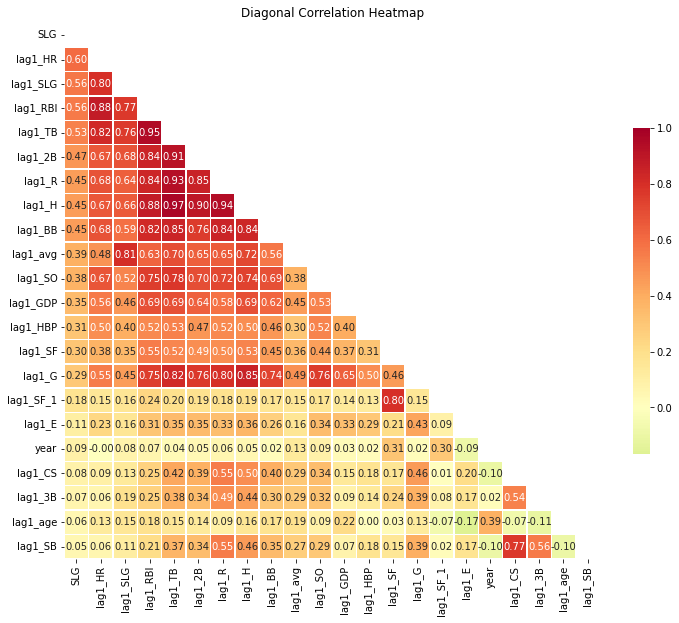

In [ ]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','OBP'],axis=1).columns)
regular_season_temp = regular_season_df[numeric_cols+['year','batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB']>=30]

# 시간 변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
  regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('SLG')
regular_season_temp.drop(numeric_cols, axis=1, inplace=True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by='SLG', axis=0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12,12))
corr = regular_season_temp.select_dtypes(exclude=['object','bool']).corr()

# 대각 행렬을 기준으로 한쪽만 나타나게 설정
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220,10, as_cmap=True)
g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax=1, mask=mask, center=0, annot=True, fmt='.2f', square=True, linewidth=.5, cbar_kws={'shrink':.5})
plt.title('Diagonal Correlation Heatmap')

- 특정 연도의 SLG와 1년 전 시점의 SLG가 높은 상관성을 띄고 있다.
- 1년 전 홈런 개수와 같이 SLG와 높은 상관관계를 보여주는 지표가 더 존재하지만, 이들은 1년 전 SLG와 높은 상관관계를 보인다
=> 따라서 SLG를 예측하는 데는 해당 선수의 과거 SLG만 이용하겠다

In [ ]:
# day_by_day에서 연도별 선수의 시즌 상반기 장타율(SLG)과 관련된 성적 합 구하기
sum_hf_yr_SLG = day_by_day_df.loc[day_by_day_df['date']<=7.18].groupby(['batter_name','year'])['AB','H','2B','3B','HR'].sum().reset_index()

# 상반기 장타율 계산
sum_hf_yr_SLG['SLG']=(
    sum_hf_yr_SLG['H'] - sum_hf_yr_SLG[['2B','3B','HR']].sum(axis=1) +
    sum_hf_yr_SLG['2B']*2 + sum_hf_yr_SLG['3B']*3 + sum_hf_yr_SLG['HR']*4
) / sum_hf_yr_SLG['AB']

# SLG 결측치를 0으로 처리
sum_hf_yr_SLG['SLG'].fillna(0, inplace=True)

# 필요한 칼러만 불러오고 나이 계산
sum_hf_yr_SLG = sum_hf_yr_SLG[['batter_name','year','AB','SLG']]
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(regular_season_df[['batter_name','year','age']],how='left',on=['batter_name','year'])

sum_hf_yr_SLG.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,batter_name,year,AB,SLG,age
0,가르시아,2018,85,0.552941,33
1,강경학,2011,1,0.000000,19
2,강경학,2014,0,0.000000,22
3,강경학,2015,156,0.333333,23
4,강경학,2016,81,0.222222,24


In [ ]:
# SLG 3년 전 성적까지 변수를 생성
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG,'SLG',1)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG,'SLG',2)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG,'SLG',3)

display(sum_hf_yr_SLG.head())

round(sum_hf_yr_SLG[['lag1_SLG','lag2_SLG','lag3_SLG']].isna().sum()/sum_hf_yr_SLG.shape[0],2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG
0,가르시아,2018,85,0.552941,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,0.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.333333,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.333333,NaN,NaN


lag1_SLG    0.41
lag2_SLG    0.54
lag3_SLG    0.61
dtype: float64

In [ ]:
# 선수별 SLG 평균 데이터(player_SLG_mean)를 만듭니다
player_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','2B','3B','HR'].sum().reset_index()
player_SLG_mean['mean_SLG'] = \
    (player_SLG_mean['H'] - player_SLG_mean[['2B','3B','HR']].sum(axis = 1) +
     player_SLG_mean['2B']*2 + player_SLG_mean['3B']*3 + player_SLG_mean['HR']*4
    ) / player_SLG_mean['AB']

# 시즌별 SLG 평균 데이터(season_SLG_mean)를 만듭니다
season_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','2B','3B','HR'].sum().reset_index()
season_SLG_mean['mean_SLG'] = \
    (season_SLG_mean['H'] - season_SLG_mean[['2B','3B','HR']].sum(axis = 1) + 
     season_SLG_mean['2B']*2 + season_SLG_mean['3B']*3 + season_SLG_mean['HR']*4
    ) / season_SLG_mean['AB']

# 선수 평균의 SLG(player_OBP_mean)를 새로운 변수로 더합니다.
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(player_SLG_mean[['batter_name', 'mean_SLG']],
                                    how='left', on="batter_name")

# 선수 평균의 성적이 결측치이면 데이터에서 제거합니다.
sum_hf_yr_SLG = \
    sum_hf_yr_SLG.loc[~sum_hf_yr_SLG['mean_SLG'].isna()].reset_index(drop=True)

# 결측치 처리
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 1, season_SLG_mean) #1년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 2, season_SLG_mean) #2년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 3, season_SLG_mean) #3년전 성적 대체

display(sum_hf_yr_SLG.head())
round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG,mean_SLG_x,mean_SLG_y,mean_SLG_x,mean_SLG_y,mean_SLG
0,가르시아,2018,85,0.552941,33,0.481855,0.481498,0.476627,0.519126,0.519126,0.519126,0.519126,0.519126
1,강경학,2011,1,0.000000,19,0.372902,0.380882,0.361716,0.332527,0.332527,0.332527,0.332527,0.332527
2,강경학,2014,0,0.000000,22,0.362931,0.349344,0.359616,0.332527,0.332527,0.332527,0.332527,0.332527
3,강경학,2015,156,0.333333,23,0.389415,0.362931,0.349344,0.332527,0.332527,0.332527,0.332527,0.332527
4,강경학,2016,81,0.222222,24,0.333333,0.389415,0.362931,0.332527,0.332527,0.332527,0.332527,0.332527


lag1_SLG    0.0
lag2_SLG    0.0
lag3_SLG    0.0
dtype: float64

In [ ]:
sum_hf_yr_OBP.to_csv('/content/drive/MyDrive/Dacon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/sum_hf_yr_OBP.csv')
sum_hf_yr_SLG.to_csv('/content/drive/MyDrive/Dacon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/sum_hf_yr_SLG.csv')
regular_season_df.to_csv('/content/drive/MyDrive/Dacon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/Regular_Season_Batter.csv')
day_by_day_df.to_csv('/content/drive/MyDrive/Dacon_Practice/KBO 타자 OPS/62540_KBO_prediction_data/Regular_Season_Batter_Day_by_Day_b4.csv')
preseason_df.to_csv('')